# Interact with Processed Spatial Data Objects

## Setup

* `object_suffix`: In case the `h5ad` file for the processed object has a suffix after the sample ID (e.g., `Uninflamed-50336C_downstream.h5ad`).
* `col_leiden`: Leiden cluster column name.
* `file_ann`: File containing mappings of Leiden clusters to cell type labels/annotations. 
  * See the "Annotation" section below for more details. 
  * Set to `None` if you want to use just Leiden clusters, use imputation (Tangram) predictions, or if the annotations have already been added to the object.
* `col_annotation`: Name of column in `file_ann` to use for annotations. (Ignored if `tangram=True`.)
* `col_annotation_new`: Name of column that already exists or (if `file_ann` is specified) to create in `self.rna.obs` and to use by default in future functions after the "Annotation" section is run.
  * Using the Leiden column by default (until annotation is performed) is accomplished by setting `col_cell_type=col_leiden` in the object initialization (`cr.Spatial(...)`), which allow you not to have to manually specify the `col_cell_type` arguments in downstream methods. You can always change this default later with `self._columns["col_cell_type"] = "COLUMN NAME HERE"`.
  * If you run the optional "Annotation" section, this default will be changed to the new annotation column.
  * If you want to use a different column just for one method/function call, just specify the `col_cell_type` argument in that particular method (e.g., if `self._columns["col_cell_type"]` is "lump_res1pt5_dist0_npc30" and you want to plot the Leiden clusters just for a one-off plot, run `self.plot_spatial(col_cell_type="leiden_res1pt5_dist0_npc30")` instead of just `self.plot_spatial()`).
  * You can see current defaults using `print(self)`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import functools
import warnings
import spatialdata
import spatialdata_plot
import spatialdata_io as sdio
import numpy as np
import pandas as pd
import corescpy as cr

# Sample Selection & Other Options
libid = "50336C"
panel_id = "TUQ97N"
object_suffix = "_downstream"
# object_suffix = ""
# libid = "1014A2"
# panel_id = "XR4UZH"
tangram = False  # use the whole transcriptome-imputed object if available?
col_leiden = "leiden_res1pt5_dist0_npc30"  # Leiden clusters column name

# File Paths
ddd = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library"
          )  # where processed objects, metadata, future outputs live
dir_data = f"/mnt/cho_lab/bb-xenium-registry/outputs/{panel_id}"  # data
out_dir = os.path.join(ddd, f"outputs/{panel_id}/nebraska")  # to save outputs
file_mdf = os.path.join(ddd, f"samples_{panel_id}.csv")  # metadata path

# Annotations (Optional)
# file_ann = None
file_ann = os.path.join(out_dir,
                        "annotation_dictionaries/annotations_all.xlsx")
col_annotation = "lump"  # column in `file_ann` to use for annotations

# Images (Optional)
image_type = "he"  # sub-directory of tissue-registry/xenium/<PANEL>
dir_image = str("/mnt/cho_lab/bb-nfs-data-registries/tissue-registry/"
                f"xenium/{panel_id}/{image_type}")

# Find File Path & Condition-ID String
  # Find Data Path Automatically
m_d = cr.pp.get_metadata_cho(
      dir_data, file_mdf, samples=libid, path_col_only=True,
      panel_id=panel_id, capitalize_sample=panel_id == "TUQ97N")  # metadata
dir_oba = m_d.iloc[0]  # Xenium data path
lib = m_d.index.values[0]  # newly-constructed sample ID
file_image = os.path.join(dir_image, f"ome-tiff/{lib}.ome.tif")  # image file
file_align = os.path.join(dir_image, f"alignment/{lib}/matrix.csv")  # align
file_tg = os.path.join(out_dir, f"{lib}_tangram.h5ad")  # imputed whole tx'ome
if tangram is True and not os.path.exists(file_tg):
    raise ValueError(f"{file_tg} does not exist. Change `file_tg` to the "
                     "proper file path or set `tangram=False`")
col_annotation_new = f"{col_annotation}_" + col_leiden.split(
    "leiden_")[1] if tangram is False else "tangram_prediction"
file_object = file_tg if tangram else os.path.join(
    out_dir, f"{lib}{object_suffix}.h5ad")  # processed object file
print("\n\n\n", lib, "\n", dir_oba)




 Uninflamed-50336C 
 /mnt/cho_lab/bb-xenium-registry/outputs/TUQ97N/CHO-010/output-XETG00189__0011047__50336C-TUQ97N-EA__20240422__175051


## Load Data

Load the spatial data. Optionally, update it with the processed object.

Loading the data takes about 3-20 minutes on average.

Optionally, add aligned image data (e.g., H&E, IF). 
* Image data should have been converted to OME-TIFF (e.g., from NDPI) by the dry lab. 
* The OME-TIFF then would have been loaded into Xenium Explorer, where image alignment would be performed and the alignment files downloaded (instructions on [Confluence](https://mssm-ipm.atlassian.net/wiki/x/BQA1bg); see also [10x](https://www.10xgenomics.com/support/software/xenium-explorer/latest/tutorials/xe-image-alignment)). 
* The OME-TIFF and alignment files should be transferred to the image registry NFS, which is mounted on different compute environments and [can be mounted locally](https://mssm-ipm.atlassian.net/wiki/spaces/cholab/pages/857047077/Compute#Network-File-System---NFS).

In [3]:
self = cr.Spatial(dir_oba, library_id=lib, col_cell_type=col_leiden)
if os.path.exists(file_object):  # processed object?
    self.update_from_h5ad(file_object)
if os.path.exists(file_image) and os.path.exists(file_align):  # image?
    self.add_image(file_image, name=image_type, file_align=file_align)
self.adata



<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bb-xenium-registry/outputs/TUQ97N/CHO-010/output-XETG00189__0011047__50336C-TUQ97N-EA__202404
         22__175051/cell_feature_matrix.h5                                                                         


Counts: Initial: table


	Observations: 387961

	Genes: 469







 AnnData object with n_obs × n_vars = 387961 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial'
    obsm: 'spatial'
    layers: 'counts' 

                gene_ids    feature_types   genome
ABCA7   ENSG00000064687  Gene Expression  Unkno

SpatialData object
├── Images
│     ├── 'he': DataArray[cyx] (3, 59136, 84480)
│     └── 'morphology_focus': DataTree[cyx] (5, 74826, 48440), (5, 37413, 24220), (5, 18706, 12110), (5, 9353, 6055), (5, 4676, 3027)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (74826, 48440), (37413, 24220), (18706, 12110), (9353, 6055), (4676, 3027)
│     └── 'nucleus_labels': DataTree[yx] (74826, 48440), (37413, 24220), (18706, 12110), (9353, 6055), (4676, 3027)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (387961, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (387961, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (379551, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (378219, 469)
with coordinate systems:
    ▸ 'global', with elements:
        he (Images), morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_b

## See Post-Processing QC Values


	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




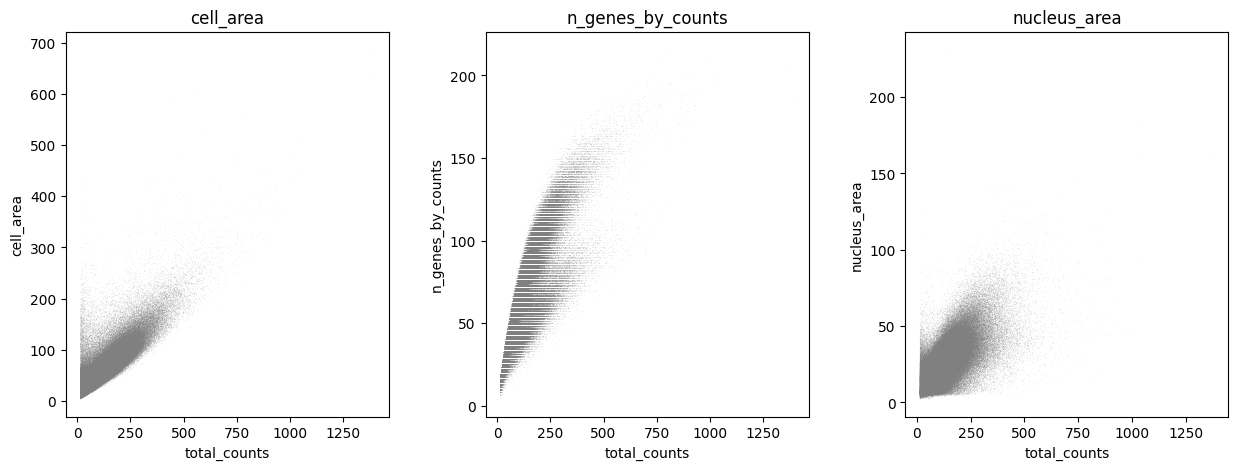

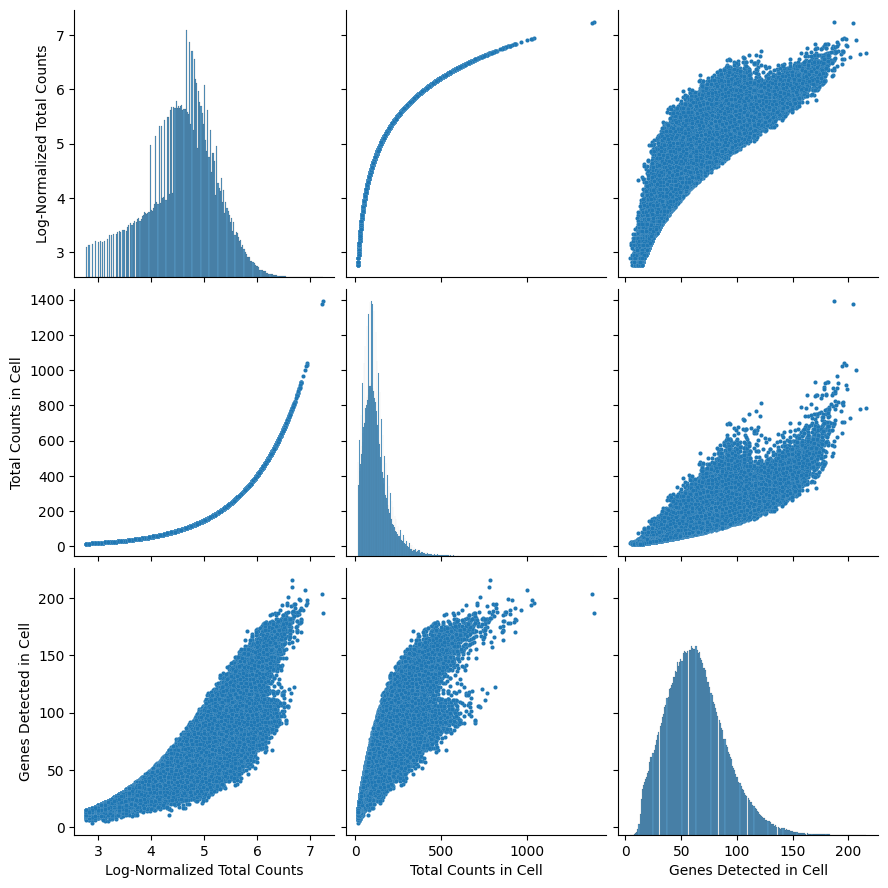

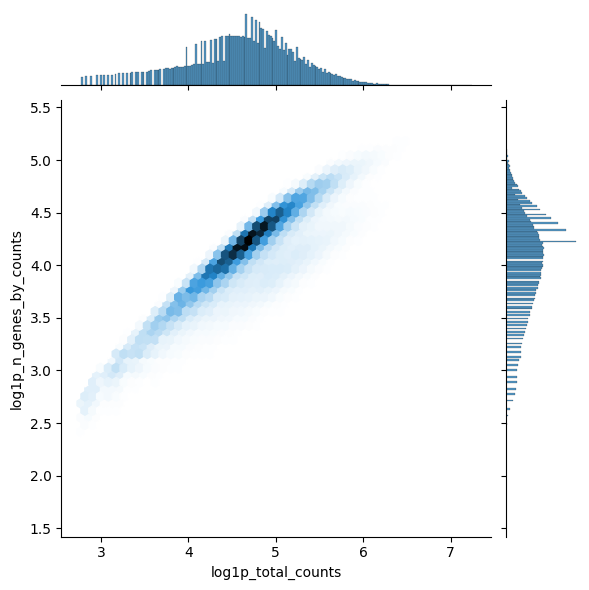

In [4]:
_ = cr.pp.perform_qc(self.rna.copy())

## Markers

This code just plots the markers/DEGs that were already calculated for `col_leiden`.

To re-run this process, use the `self.find_markers` (see the Single-Cell tutorial).

Change the `n_genes` argument to plot more or fewer markers (below, five).

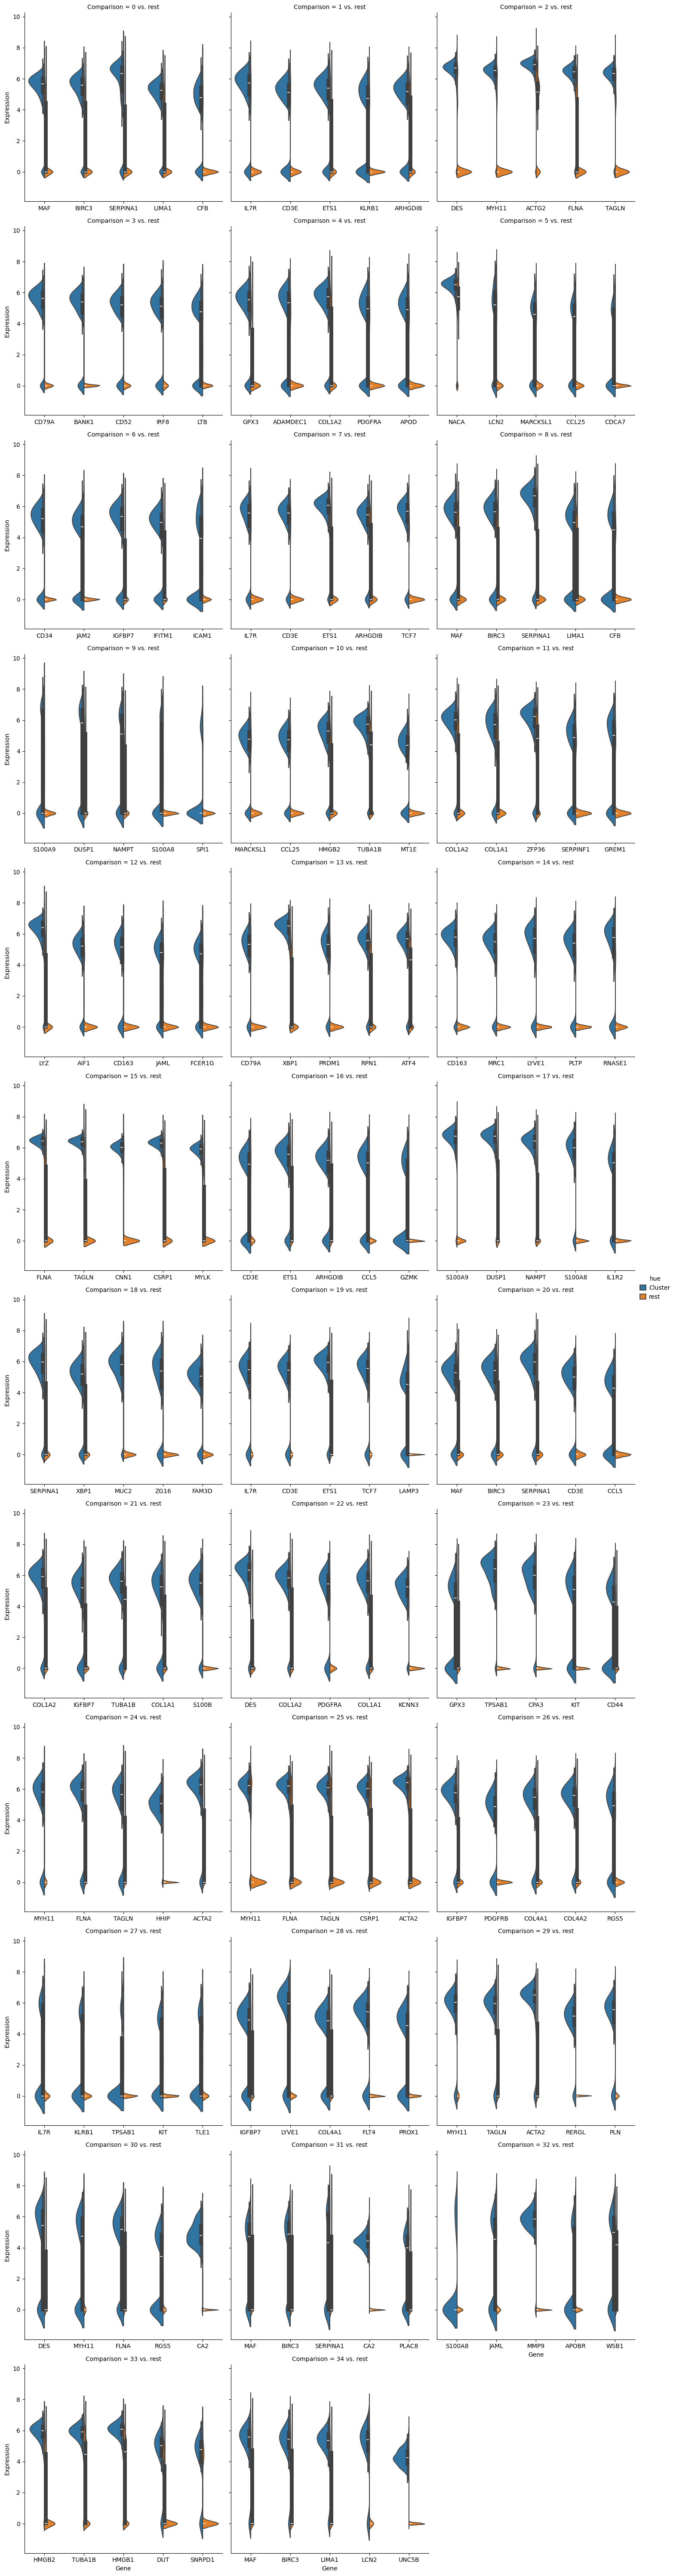

In [5]:
cr.pl.plot_markers(self.rna.copy(), n_genes=5, col_wrap=3,
                   key_added=f"rank_genes_groups_{col_leiden}")

## Annotation (Optional)

Note that running this cell also changes your default cell type label column from the Leiden clusters to the annotation.

You can perform manual annotation mapping each Leiden cluster to an annotation, save it into an Excel file, and then make a column using that mapping. (Alternatively, you can just manually construct a Python dictionary and use that instead of `dict(assign[col_assign])`.)

* The 1st column of the excel file should contain the library IDs (e.g., Uninflamed-50403A2) identifying the sample being annotated. 
* The 2nd column should contain the name of the `self.rna.obs` column that contains the Leiden clustering you're mapping labels to. 
* The 3rd column should contain the Leiden cluster labels. 
* You can have multiple columns after that containing whatever information you want, including cell type labels (annotations), additional information about the clusters, etc.
  * However, it's advisable that the first column be your desired cell type labels (e.g., B Cell) for each Leiden cluster. 
  * If you want to use a column other than the 4th column to create your labels (e.g., if your file contains the labels elsewhere, or if you have multiple versions of the annotations), change the code below (`col_assign = assign.columns[0]`) to `col_assign = <COLUMN NAME WITH YOUR DESIRED LABELS>`.

Here's an example of the top few lines (with certain rows in the middle cut out for space) of a manual annotation file with two versions (high and low resolution) of the annotations:

| Sample          | Clustering                  | cluster | annotation                  | bin         |
|-----------------|-----------------------------|---------|------------------------------|-------------|
| Uninflamed-50006B | leiden_res1pt5_dist0_npc30  | 0       | SMC                          | SMC         |
|                 |                             | 1       | Epithelial (TA)              | Epithelial  |
|                 |                             | 2       | Plasma (IgA/IgG)             | B Cell      |
|                 |                             | 3       | Epithelial (Enterocyte)      | Epithelial  |
|                 |                             | 4       | Epithelial (Secretory)       | Epithelial  |
|                 |                             | 5       | Stromal (Transitional 3)     | Stromal     |
|                 |                             | 6       | Endothelial                  | Endothelial |
| Stricture-50564A4 | leiden_res1pt5_dist0_npc30 | 0       | Plasma (IgA/IgG)             | B Cell      |
|                 |                             | 1       | B Cell                       | B Cell      |
|                 |                             | 2       | Epithelial (TA)              | Epithelial (TA) |
|                 |                             | 3       | Stromal (2)                  | Stromal     |

AnnData object with n_obs × n_vars = 378219 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'sample_id', 'subject_id', 'run_id', 'panel_id', 'slide_id', 'clinical_block', 'description', 'date_hybridization', 'date_sectioned', 'location', 'inflammation', 'stricture', 'Condition', 'Age', 'Annotation', 'CDKN1A_PLAUR_threshold2', 'CDKN1A_TP53_PLAUR_threshold2', 'CDKN1A_TP53_threshold2', 'CDKN1A_threshold2', 'Diagnosis', 'Disease_Status', 'Hispanic', 'IL7R_KLRB1_RORC_threshold2', 'IL7R_KLRB1_threshold2', 'IL7R_RORC_threshold2', 'IL7R_threshold2', 'KLRB1_RORC_threshold2', 'KLRB1_threshold2', 'PLAUR_threshold2', 'RORC_threshold2', 'Race', 'Sex', 'TP53_PLAUR_threshold2', 'TP53_threshold2', 'annotation_res0pt5_dist0pt5_npc30', 'annotation_res0pt75_dist0pt3_npc30', 'annotation_res1pt5_dist0_npc30', 'assay_protein', 'bin_res

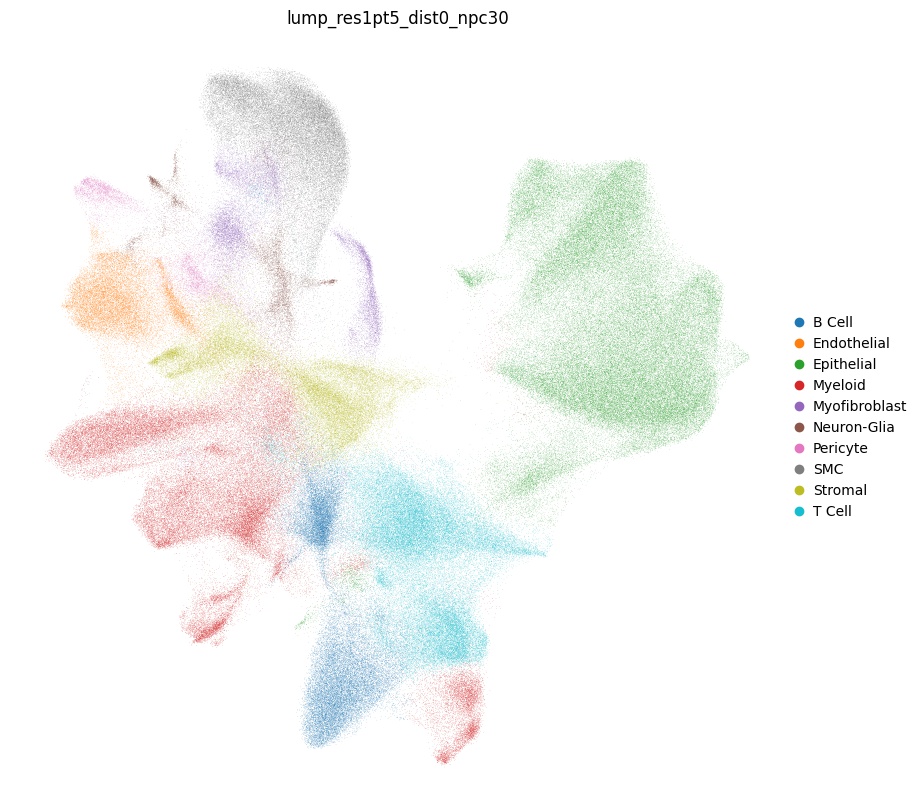




'spatial'


Plotting annotations failed!




In [47]:
# Annotate Clusters
if file_ann is not None and os.path.exists(file_ann):
    assign = pd.read_excel(file_ann, index_col=[0, 1, 2]).loc[
        self._library_id].loc[col_leiden][col_annotation]  # load annotations
    _ = self.annotate_clusters(assign, col_cell_type=col_leiden,
                               col_annotation=col_annotation_new)  # annotate

# Annotation Column = New Default Labels
if col_annotation_new not in self.rna.obs.columns:
    warnings.warn("Annotation file doesn't exist/not specified & annotation"
                  f" column {col_annotation_new} not already in data.")
else:
    self._columns["col_cell_type"] = col_annotation_new  # new default

## Plot

### Plot Morphology

In [ ]:
image_keys = [image_type, "morphology_focus"] if (
    image_type in self.adata.images) else "morphology_focus"  # images to plot
self.plot_image(image_keys)

### Plot Clusters

You can plot just one group out of the clusters by specifying some label that exists within the cell type label column in `self.rna.obs`.

In [ ]:
self.plot_umap(color="leiden_res1pt5_dist0_npc30")  # UMAP
fig_clusters = self.plot_spatial()  # spatially-resolved plot of clusters
fig_myeloid = self.plot_spatial(groups=["Myeloid"])  # plot of JUST 1 cluster

### Plot Gene Expression

### GEX Only

See the single-cell tutorial for more details.


<<< PLOTTING GEX (Heatmap) >>>

<<< PLOTTING GEX (Dot) >>>


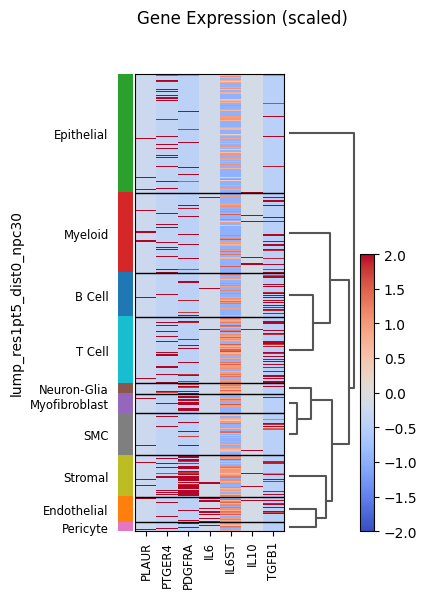

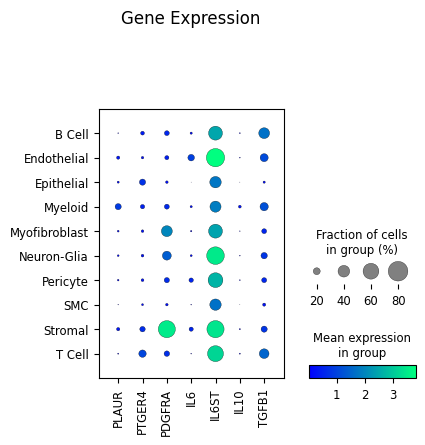


<<< PLOTTING GEX (Matrix) >>>


<Figure size 640x480 with 0 Axes>

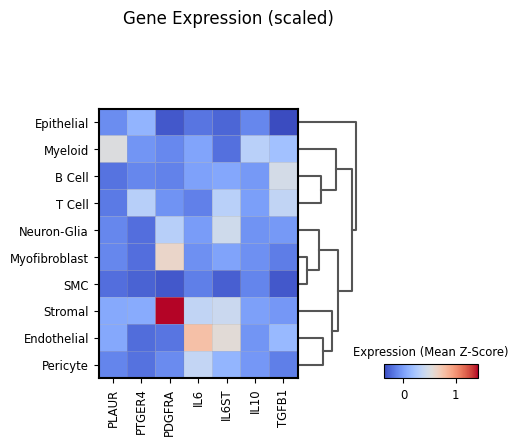


<<< PLOTTING GEX (Violin) >>>


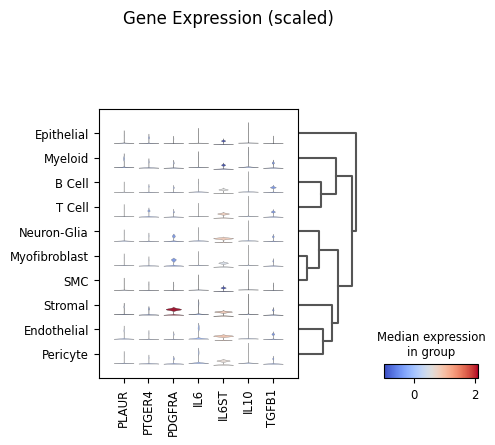

{'gex': {'violin_scaled_stacked': <scanpy.plotting._stacked_violin.StackedViolin at 0x7f06ac397ac0>,
  'violin_scaled': [<Axes: ylabel='PLAUR'>,
   <Axes: ylabel='PTGER4'>,
   <Axes: ylabel='PDGFRA'>,
   <Axes: ylabel='IL6'>,
   <Axes: ylabel='IL6ST'>,
   <Axes: ylabel='IL10'>,
   <Axes: ylabel='TGFB1'>]}}

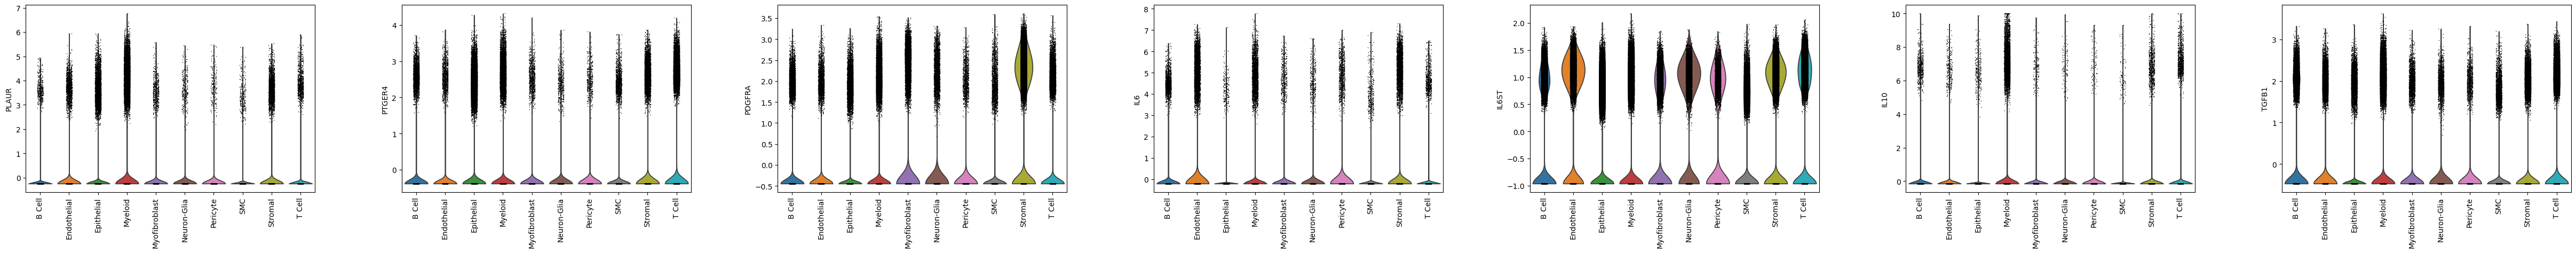

In [ ]:
genes = ["PLAUR", "PTGER4", "PDGFRA", "IL6", "IL6ST", "IL10", "TGFB1"]
self.plot(genes, kind="heat", layer="scaled", kws_heat=dict(vmin=-2, vmax=2))
self.plot(genes, kind="dot", layer="scaled")
self.plot(genes, kind="matrix", layer="scaled")
self.plot(genes, kind="violin", layer="scaled")

### Spatially-Resolved

You can plot gene expression within the tissue (spatially-resolved) by specifying a gene name.

In [ ]:
for x in ["PLAUR", "PTGER4", "PDGFRA", "IL6", "IL6ST", "IL10", "TGFB1"]:
    fig_gex = self.plot_spatial(color=x, figsize=(15, 15))

## Analyze

Also refer to the `Single-Cell` tutorial for cross-applicable workflows (e.g., `self.find_markers()`, `self.plot()`, `self.quantify_cells()`).

### Quantify (Co-)Expression Percentages

#### Expression

Quantify and plot the number and percentage of cells in each cluster that are positive for each gene individually.

The function counts a cell as positive for a gene if it has a gene expression score `> threshold` in the specified layer. For instance, for `threshold=0, layer="counts"`, it will count cells with any expression, i.e., with `self.rna.layers["counts"] > 0`. 

You could also specify, for example, `threshold=1, layer="counts"` to see percentages with 2 or more counts, or `threshold=0, layer="scaled"` to see cells with a positive scaled/zero-centered score.

In [ ]:
perc_exp = self.quantify_cells(["PLAUR", "PTGER4", "PDGFRA"], threshold=0,
                               layer="counts")  # group by default labels
# perc_exp = self.quantify_cells(["PLAUR", "PTGER4", "PDGFRA"], threshold=0
#                                col_cell_type=col_leiden,
#                                layer="counts",)  # group by Leiden clusters

#### Co-Expression

You can specify 
* a list containing a list of genes (instead of just a list or list of strings; notice the double brackets `[[gene 1, gene 2, ...]]` rather than `[gene 1, gene 2, ...]`) to calculate co-expression of multiple genes in the same cell, or
* a list with more than one list of genes in it (e.g., `self.quantify_cells([["PLAUR", "PTGER4", "PDGFRA"], ["CDKN1A", "TP53"]], threshold=0)`) to do calculations for multiple sets of genes.
  
You can set the `min_genes` parameter to relax the default of requiring all genes to be expressed above the threshold in order to count the cell as positive. 
* For instance, if you have a list of 20 markers for a cell type of interest, you wouldn't necessarily expect them *all* to always be co-expressed in that cell type, 
* but maybe you're pretty confident that a cell is of that type if at least three of the markers are co-expressed. 
* Set `min_genes=3`, and cells will be counted as positive if any three or more of the genes are expressed within a cell above the threshold.

In [ ]:
coexp = self.quantify_cells(
    [["PLAUR", "PTGER4", "PDGFRA"], ["CDKN1A", "TP53"]],
    layer="counts", threshold=0)

coexp_3 = self.quantify_cells([["NKG7", "PRF1", "ETS1", "CCL5", "TXNIP"]],
                              layer="counts", threshold=0,
                              min_genes=3)  # only 3 genes need to be > 0

### Spatial Analyses

The following code shows how to plot previous results stored in the object. To (re-)run these analyses, see the downstream spatial tutorials/workflows.

#### Neighborhood Enrichment

Plot results from `self.calculate_neighborhood()`.

In [ ]:
fig_nb = self.plot_neighborhood()

#### Spatially-Variable Genes

Plot results from `self.find_svgs()`.

              I  pval_norm      var_norm  pval_z_sim  pval_sim       var_sim  \
BANK1  0.570473        0.0  8.961561e-07         0.0  0.090909  2.349533e-06   
ZG16   0.466488        0.0  8.961561e-07         0.0  0.090909  4.863047e-07   
CCL19  0.461155        0.0  8.961561e-07         0.0  0.090909  7.508509e-07   
LTB    0.403699        0.0  8.961561e-07         0.0  0.090909  6.005888e-07   
LGR5   0.364647        0.0  8.961561e-07         0.0  0.090909  1.303384e-06   
IL6    0.335993        0.0  8.961561e-07         0.0  0.090909  1.864834e-06   
RERGL  0.319300        0.0  8.961561e-07         0.0  0.090909  6.226478e-07   
CXCL8  0.309088        0.0  8.961561e-07         0.0  0.090909  1.039696e-06   
LAMP3  0.302448        0.0  8.961561e-07         0.0  0.090909  1.167837e-06   
IDO1   0.245251        0.0  8.961561e-07         0.0  0.090909  6.736448e-07   

       pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
BANK1               0.0                0.0         0.0921

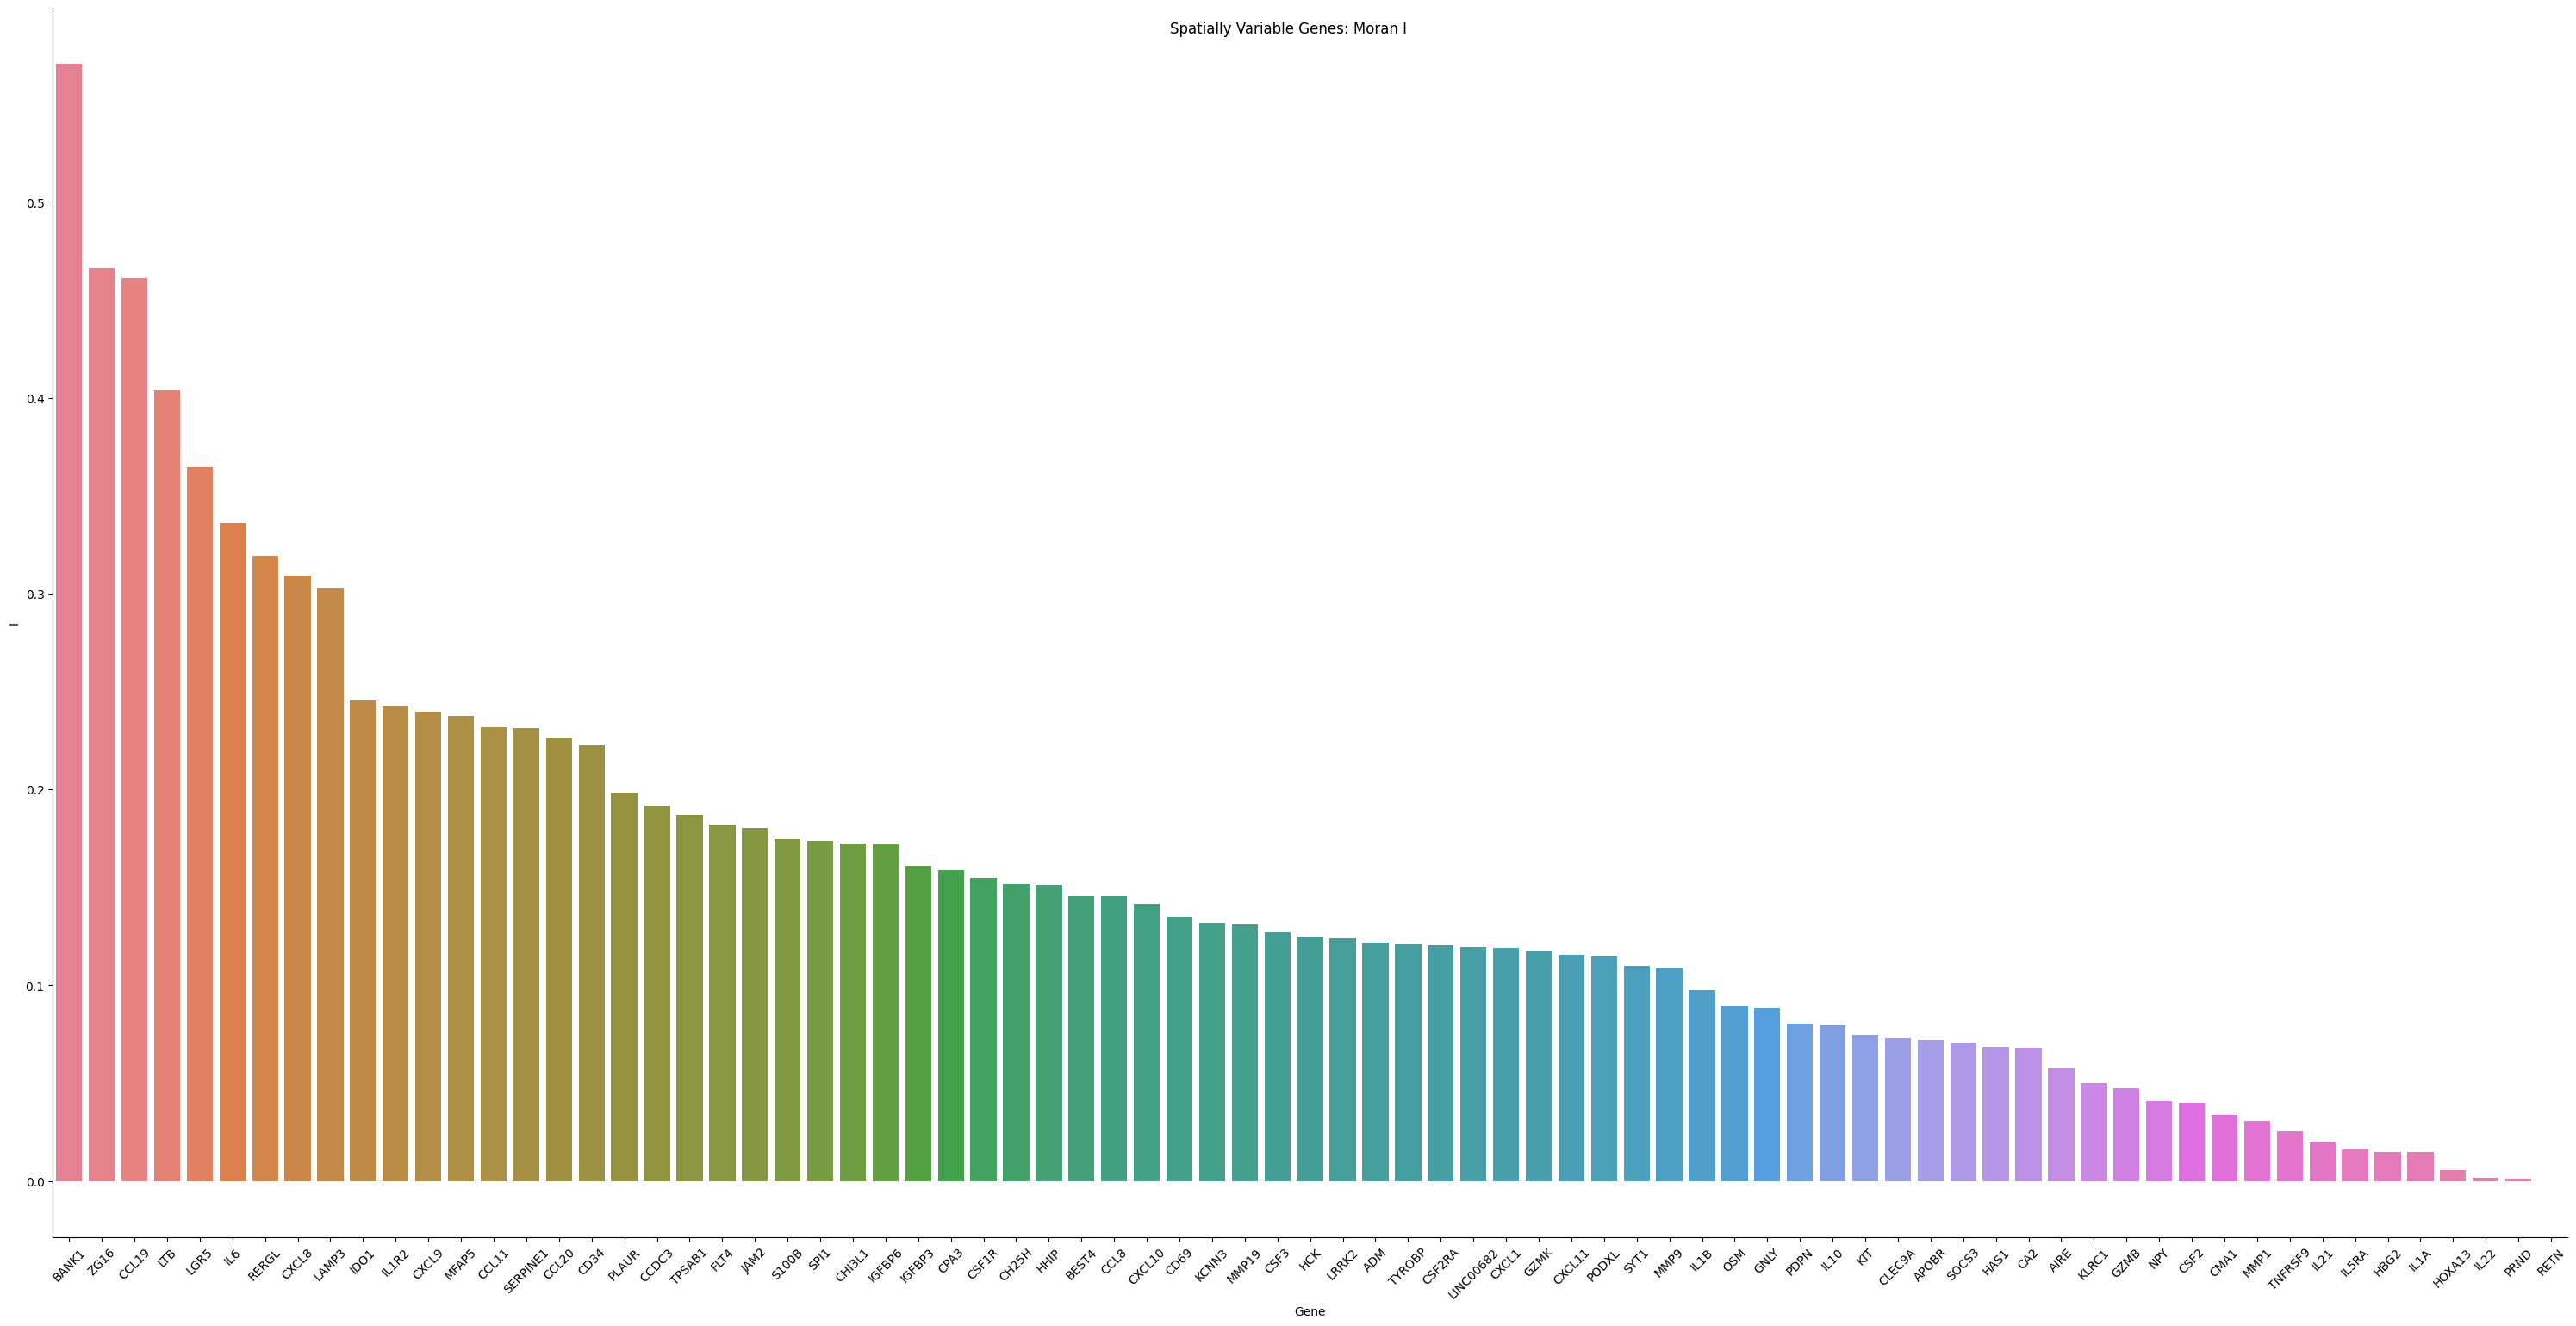

In [31]:
# self.plot_svgs()  # to plot all results metrics
fig_svg = self.plot_svgs(metrics="I", height=15, aspect=2)

#### Co-Occurrence

Plot results from `self.find_cooccurrence()`.

In [ ]:
fig_cooccur_myeloid = self.plot_cooccurrence(groups=["Myeloid"])
# fig_cooccur = self.plot_cooccurrence()  # all clusters